# Cross Validation on All Models

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold


In [2]:
anomoly  = False

# load data either by anomoly or not
if anomoly:
    X=pd.read_csv("https://raw.githubusercontent.com/KelvinYQC/msia420PA_project/main/Data/with_anomaly.csv")
else:
    X=pd.read_csv("https://raw.githubusercontent.com/KelvinYQC/msia420PA_project/main/Data/without_anomaly.csv")
y = X['booking_status']
X.drop(['booking_status'], axis = 1, inplace = True)


In [3]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=None, train_size=0.3)

## Stratified K-fold CV
Since we have imbalanced dataset, we would use stratified K-fold cross validation to test the model. In such manner, we would ensure each fold would have a representative proportion of both the majority class and minority class.


In [4]:
# Run CV for 5 folds
models = {
    # Baseline model
    "Naive Bayes" : GaussianNB(),
    # Linear model
    "Logistic Regression": LogisticRegression(),
    "RidgeClassifierCV": RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    # Non-linear model
    "Neural_Network": MLPClassifier(hidden_layer_sizes = 30,learning_rate_init = 0.001),
    "svc": SVC(C = 10, gamma = 0.1, kernel = 'poly'),
    # Tree based model
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 800,min_samples_split= 5,min_samples_leaf=1,max_features="sqrt", max_depth= 100),
    "XGBoost": xgb.XGBClassifier(max_depth=15, learning_rate=None),
}

# Create folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=10)

# Run for k folds to find best model.
cv_scores = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("clf", model)])
    cur_score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring = "roc_auc"))
    cv_scores[name] = cur_score
print(cv_scores)


{'Naive Bayes': 0.7934784789992383, 'Logistic Regression': 0.8554749144324799, 'RidgeClassifierCV': 0.8553588347600939, 'Neural_Network': 0.8930518188193989, 'svc': 0.8825549709734914, 'DecisionTreeClassifier': 0.8224114514980566, 'Random Forest': 0.9373128209043726, 'XGBoost': 0.9337680717445344}


In [6]:
for i , v in sorted(cv_scores.items(), key = lambda x:x[1]):
    print((i,v))

('Naive Bayes', 0.7934784789992383)
('DecisionTreeClassifier', 0.8224114514980566)
('RidgeClassifierCV', 0.8553588347600939)
('Logistic Regression', 0.8554749144324799)
('svc', 0.8825549709734914)
('Neural_Network', 0.8930518188193989)
('XGBoost', 0.9337680717445344)
('Random Forest', 0.9373128209043726)


## Final model

### Fit the final model

In [7]:
final_model = RandomForestClassifier(n_estimators = 800,min_samples_split= 5,min_samples_leaf=1,max_features="sqrt", max_depth= 100)
final_pip = Pipeline(steps=[("scaler", StandardScaler()), ("clf", final_model)])

final_pip.fit(X_train, y_train)
final_model = final_pip.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
classifier_score_xgb = roc_auc_score(y_test, y_pred)

print("The final roc auc score: ")
print(round(classifier_score_xgb,3))



The final roc auc score: 
0.859


### Variable Importance Plot

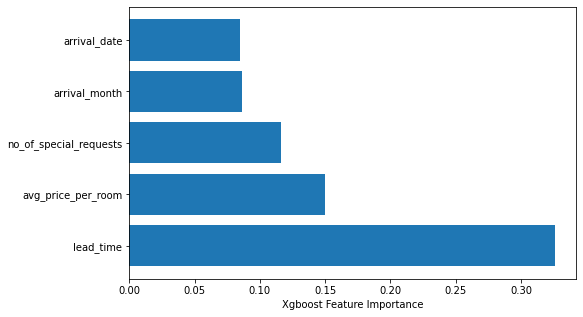

In [8]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
model = final_model["clf"]
sorted_idx = model.feature_importances_.argsort()[::-1]
top_n = 5  # Specify the number of top variables you want to display

plt.figure(figsize=(8, 5))  # Set the figure size
plt.barh(range(top_n), model.feature_importances_[sorted_idx][:top_n], align='center')
plt.yticks(range(top_n), X_test.columns[sorted_idx][:top_n])
plt.xlabel("Xgboost Feature Importance")

plt.show()
